In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline  

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
# In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with lagged CAD/JPY exchange rate returns.  

# Currency pair exchange rates for CAD/JPY

cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()


Bad key "text.kerning_factor" on line 4 in
C:\Users\mknitchov\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [2]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


In [7]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s

cad_jpy_df['Return'] = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = cad_jpy_df.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


In [8]:
# Create a lagged return using the shift function

cad_jpy_df['Lagged Return'] = cad_jpy_df["Return"].shift()
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.tail()

,Price,Open,High,Low,Return,Lagged Return
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


In [9]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training

train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [10]:
# Create four dataframes:
# X_train (training set using just the independent variables)
x_train = train["Lagged Return"].to_frame()

# X_test (test set of of just the independent variables)
x_test = test["Lagged Return"].to_frame()

# Y_train (training set using just the "y" variable, i.e., "Futures Return")
y_train = train["Return"]

#Y_test (test set of just the "y" variable)
y_test = test["Return"]

In [12]:
 # Preview the X_train data
x_train.tail()

,Lagged Return
Date,
2017-12-25,-0.011240
2017-12-26,0.033723
2017-12-27,0.269693
2017-12-28,0.392245
2017-12-29,0.256754


In [15]:
# Create a Linear Regression model and fit it to the training data

from sklearn.linear_model import LinearRegression


In [16]:
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):

linreg_model = LinearRegression()
linreg_model.fit(x_train, y_train)

LinearRegression()

In [20]:
# Make a prediction of "y" values using just the test dataset

predictions = linreg_model.predict(x_test)

In [23]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:

results = y_test.to_frame()
results["Predicted Return"] = predictions
results.head(10)

,Return,Predicted Return
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366
2018-01-08,-0.087787,-0.024437
2018-01-09,-0.724876,0.001157
2018-01-10,-1.747981,0.017349
2018-01-11,0.067560,0.043353


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027C2D83FA88>,
      dtype=object)

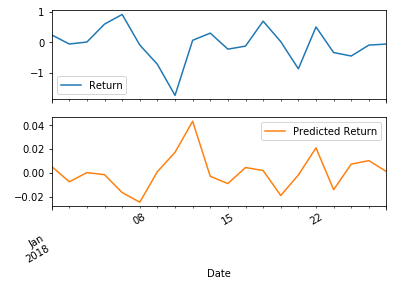

In [24]:
# Plot the first 20 predictions vs the true values

results[:20].plot(subplots=True)

In [25]:
from sklearn.metrics import mean_squared_error

In [35]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)

mse = mean_squared_error(
    results["Return"],
    results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out of Sample Root Mean Squared Error: {rmse}")


Out of Sample Root Mean Squared Error: 0.6445805658569028


In [34]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:
in_sample_results["In-Sample Predictions"] = linreg_model.predict(x_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-Sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-Sample Root Mean Squared Error: {in_sample_rmse}")

In-Sample Root Mean Squared Error: 0.841994632894117


In [ ]:
# Conclusion

# The model performs better using out-of-sample data as opposed to in-sample data. 